# COURSE: A deep understanding of deep learning
## SECTION: Autoencoders
### LECTURE: Denoising MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [1]:
# import libraries
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_8676\3064566235.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Use GPU

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Import and process the data

In [5]:
# import dataset (comes with colab!)
data = np.loadtxt(open('FFN/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Create the DL model

In [6]:
# create a class for the model
def createTheMNISTAE(n_encode: int, n_bottleneck: int):

  class aenet(nn.Module):
    def __init__(self, n_encode: int, n_bottleneck: int):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,n_encode)
      
      ### encoder layer
      self.enc = nn.Linear(n_encode,n_bottleneck)

      ### latent layer
      self.lat = nn.Linear(n_bottleneck,n_encode)

      ### decoder layer
      self.dec = nn.Linear(n_encode,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y
  
  # create the model instance
  net = aenet(n_encode, n_bottleneck)
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Test the model

In [11]:
# test the model with a bit of data on the CPU and GPU
net,lossfun,optimizer = createTheMNISTAE(500, 10)

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

net.to(device)
dataTD = dataT.to(device)
net(dataTD)

torch.Size([5, 784])
torch.Size([5, 784])


tensor([[0.5189, 0.5258, 0.5002,  ..., 0.4708, 0.4897, 0.5072],
        [0.5176, 0.5257, 0.4992,  ..., 0.4733, 0.4875, 0.5108],
        [0.5212, 0.5281, 0.4989,  ..., 0.4706, 0.4890, 0.5069],
        ...,
        [0.5193, 0.5308, 0.4986,  ..., 0.4709, 0.4870, 0.5043],
        [0.5194, 0.5254, 0.4984,  ..., 0.4734, 0.4856, 0.5125],
        [0.5216, 0.5295, 0.4968,  ..., 0.4712, 0.4873, 0.5012]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

# Create a function that trains the model

In [51]:
def create_dataloader(dataT: torch.tensor, batch_size: int):

  # Calculate how many batches we can create, and what we need to discard
  number_of_batches = dataT.shape[0] // batch_size
  samples_to_discard = dataT.shape[0] % batch_size

  # Shuffle the input data
  dataT_shuffled = dataT[torch.randperm(len(dataT))]

  # Remove excess values
  if samples_to_discard > 0:
    data_adj = dataT_shuffled[:-samples_to_discard, :]
  else:
    data_adj = dataT_shuffled

  # Create batches
  reshaped_data = data_adj.reshape((number_of_batches, batch_size, dataT.shape[-1]))

  ## Shuffle the data
  return reshaped_data

reshaped_data = create_dataloader(dataT, 32)
print(dataT.shape)
print(reshaped_data.shape)
print(dataT.flatten().size())
print(reshaped_data.flatten().size())

torch.Size([20000, 784])
torch.Size([625, 32, 784])
torch.Size([15680000])
torch.Size([15680000])


In [76]:
def function2trainTheModel(n_encode: int, n_bottleneck: int, CUDA: bool):

  # number of epochs
  numepochs = 15
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE(n_encode, n_bottleneck)

  # Load the model and data to the GPU
  if CUDA:
    net.to(device)
    dataTD = dataT.to(device)
  else:
    dataTD = dataT

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):
    sys.stdout.write(f"\rRunning... [{epochi}/{numepochs}].")
    sys.stdout.flush()

    data_loader = create_dataloader(dataTD, batch_size=32)
    number_of_batches = data_loader.shape[0]
    for X in data_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat, X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # losses in this epoch
      losses[epochi] += loss.item() / number_of_batches
  # end epochs

  # function output
  return losses,net.cpu()

# Run the model and show the results!

In [77]:
from time import perf_counter

encoding_sizes = np.linspace(10, 500, 12).astype(int)
bottleneck_sizes = np.linspace(5, 100, 8).astype(int)

losses = np.zeros((len(encoding_sizes), len(bottleneck_sizes)))

cuda_start = perf_counter()
for es_idx, es in enumerate(encoding_sizes):
  for bs_idx, bs in enumerate(bottleneck_sizes):
    print(f"\nRunning encoding size: {es} and bottleneck size: {bs}.")
    losses[es_idx, bs_idx] = torch.mean(function2trainTheModel(es, bs, CUDA=True)[0][-3:]).item()
cuda_end = perf_counter()

cpu_start = perf_counter()
for es_idx, es in enumerate(encoding_sizes):
  for bs_idx, bs in enumerate(bottleneck_sizes):
    print(f"\nRunning encoding size: {es} and bottleneck size: {bs}.")
    losses[es_idx, bs_idx] = torch.mean(function2trainTheModel(es, bs, CUDA=False)[0][-3:]).item()
cpu_end = perf_counter()

print(f"Done! CUDA: [{cuda_end - cuda_start:.2f}s] CPU: [{cpu_end - cpu_start:.2f}s]")


Running encoding size: 10 and bottleneck size: 5.
Running... [14/15].
Running encoding size: 10 and bottleneck size: 18.
Running... [14/15].
Running encoding size: 10 and bottleneck size: 32.
Running... [14/15].
Running encoding size: 10 and bottleneck size: 45.
Running... [14/15].
Running encoding size: 10 and bottleneck size: 59.
Running... [14/15].
Running encoding size: 10 and bottleneck size: 72.
Running... [14/15].
Running encoding size: 10 and bottleneck size: 86.
Running... [14/15].
Running encoding size: 10 and bottleneck size: 100.
Running... [14/15].
Running encoding size: 54 and bottleneck size: 5.
Running... [14/15].
Running encoding size: 54 and bottleneck size: 18.
Running... [14/15].
Running encoding size: 54 and bottleneck size: 32.
Running... [14/15].
Running encoding size: 54 and bottleneck size: 45.
Running... [14/15].
Running encoding size: 54 and bottleneck size: 59.
Running... [14/15].
Running encoding size: 54 and bottleneck size: 72.
Running... [14/15].
Runnin

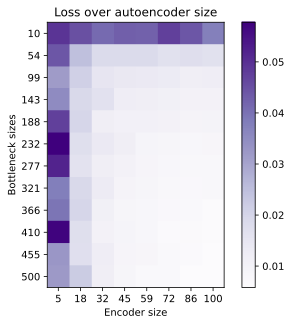

In [20]:

plt.figure()

plt.imshow(losses, cmap="Purples")
plt.colorbar()
plt.yticks(range(len(encoding_sizes)), encoding_sizes)
plt.xticks(range(len(bottleneck_sizes)), bottleneck_sizes)

plt.xlabel("Encoder size")
plt.ylabel("Bottleneck sizes")
plt.title("Loss over autoencoder size")

plt.show()
